# 🚩 Section 4 : Deep Learning 프로젝트의 목적
1. 내가 설정한 포지션에서 적합한 데이터셋 을 구한 뒤 그에 맞는 가설을 세우고 가설을 검증합니다.
2. 가설 검증을 위한 딥러닝 파이프라인을 구축합니다.
3. 구축한 파이프라인은 완벽하지 않아도 되며, 큰 가설의 일부(곁 가지)에 대한 검증을 목표로 해도 좋습니다.
4. 모자란 부분에 대해서는 이후 프로젝트를 통해서 연계해 나가도 좋으며 이런 부분은 '한계점 및 추후 발전 방향' 등을 통해 제시해 주어도 됩니다.

## HAM10000 dataset사용
흑색종 검출을 위한 피부병변분석(흑색종은 피부암 사망의 압도적 다수를 차지함)
                                (조기 발견시 생존율 95%이상)
- 10015개의 이미지 파일(kaggle)(600x450)
- 피부암 Mnist
- 피부병변 분류(7가지)
    - 'akiec': 'Actinic keratoses(광선 각화증)' 0
    - 'bcc': 'Basal cell carcinoma(기저세포암종)' 1
    - 'bkl': 'Benign keratosis-like lesions(양성 병변 각화증)' 2
    - 'df': 'Dermatofibroma(피부섬유종)' 3
    - 'mel': 'Melanoma(흑색종)' 4
    - 'nv': 'Melanocytic nevi(멜라닌세포 모반)' 5
    - 'vasc': 'Vascular lesions(혈관성 병변)' 6

- 이미지 메타데이터(metadata.csv)
    - lesion_id(7470 unique values) : 병변 부위
    - image_id(10015 unique values) : 이미지(lesion_id 확대)
    - dx : 피부병변
    - dx_type : 병변 확인방법
        - histo : 조직병리학
        - follow_up : 추적검사
        - consensus : 전문가 의견
        - confocal : 공초점 현미경 검사
    - age : 환자나이
    - sex : 환자성별
    - localization : 병변부위 위치

In [145]:
import tensorflow

In [1]:
import os
from glob import glob

# 이미지 디렉토리설정
base_dir = os.path.join(os.getcwd(), 'HAM')
# 이미지 별 경로
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

In [2]:
import pandas as pd

skin_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [3]:
pd.Categorical(skin_df['dx'])

['bkl', 'bkl', 'bkl', 'bkl', 'bkl', ..., 'akiec', 'akiec', 'akiec', 'akiec', 'mel']
Length: 10015
Categories (7, object): ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [4]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['type_idx'] = pd.Categorical(skin_df['dx']).codes
#병변 별 인덱스 카테고리, 경로 추가

skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,2


### 전처리

In [5]:
skin_df.info()             # 데이터 타입

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   path          10015 non-null  object 
 8   type_idx      10015 non-null  int8   
dtypes: float64(1), int8(1), object(7)
memory usage: 635.8+ KB


In [6]:
skin_df.isnull().sum()     # 결측치 확인

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
type_idx         0
dtype: int64

In [7]:
skin_df.dropna(axis=0, inplace =True) # 결측치 삭제

#### EDA

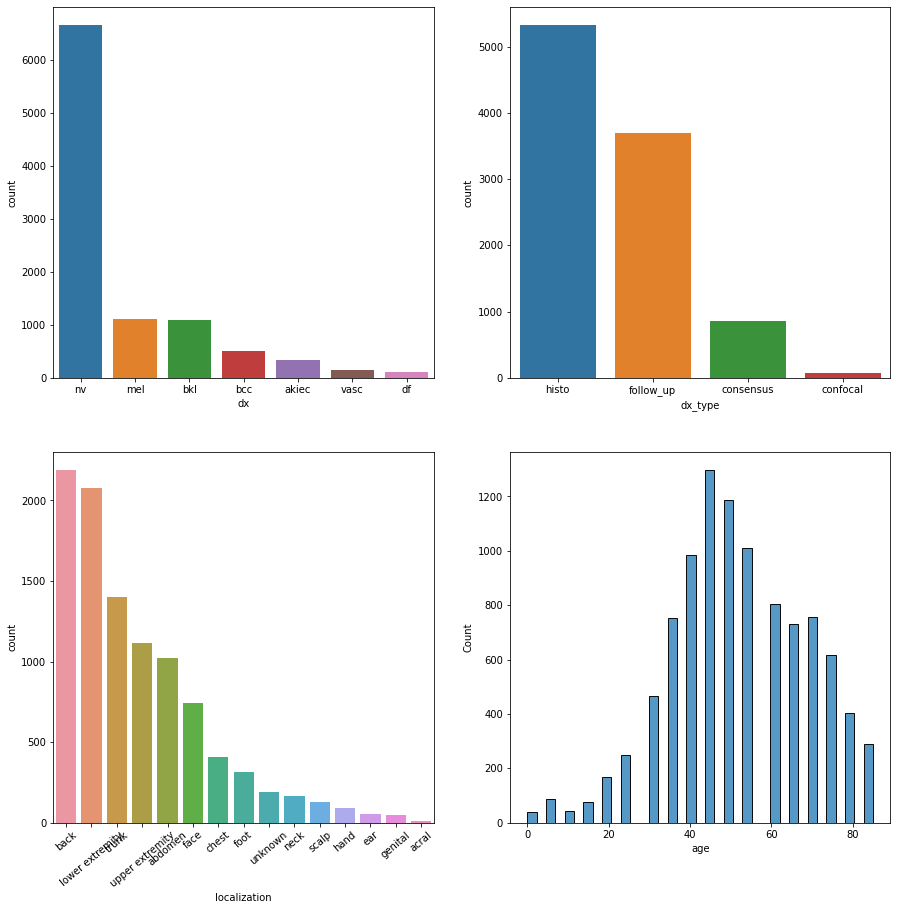

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,15))

plt.subplot(221)
sns.countplot(x='dx', data=skin_df, order=skin_df['dx'].value_counts().index)

plt.subplot(222)
sns.countplot(x='dx_type', data=skin_df, order=skin_df['dx_type'].value_counts().index)

plt.subplot(223)
plt.xticks(rotation = 40 )
sns.countplot(x='localization', data=skin_df, order=skin_df['localization'].value_counts().index)

plt.subplot(224)
sns.histplot(x= 'age', data=skin_df)
plt.show()

In [9]:
# 해당 데이터는 nv(멜라닌세포 모반) 병변의 데이터가 대다수이고(imbalanced)
# 주로 조직검사, 추적검사를 통해 확인되었으며
# 병변은 주로 등과 하체쪽에 나타나고
# 40~50대한테 주로 발병하는 것으로 보여진다.

In [10]:
import numpy as np
from PIL import Image

# 경로를 통해 이미지 불러온 후 numpy배열로 변환하기
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,100))))
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,2,"[[[191, 154, 196], [191, 155, 197], [191, 149,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,2,"[[[24, 13, 22], [24, 14, 25], [29, 17, 35], [4..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,2,"[[[187, 129, 139], [192, 135, 150], [197, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,2,"[[[23, 11, 18], [30, 15, 25], [50, 29, 39], [7..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,2,"[[[135, 91, 114], [152, 107, 131], [169, 125, ..."
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,0,"[[[142, 124, 133], [139, 121, 130], [135, 117,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,0,"[[[5, 6, 3], [7, 8, 5], [7, 7, 5], [12, 12, 10..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,0,"[[[114, 104, 106], [133, 121, 121], [140, 125,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,C:\Users\Yong\코드스테이츠 AI\Section Project\sectio...,0,"[[[159, 122, 145], [156, 115, 132], [158, 122,..."


In [11]:
# 타겟 레이블 선택
target=skin_df['type_idx']
features = skin_df.drop(columns=['path','type_idx'], axis=1)

In [12]:
# train, test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.20,
                                                    random_state=2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7966, 8), (1992, 8), (7966,), (1992,))

In [13]:
# image normalization
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [14]:
#conda install -c anaconda protobuf

In [15]:
#conda install -c conda-forge python-flatbuffers

In [16]:
# 7개의 typeidx로 나눠진 target 레이블 원-핫인코딩
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train, num_classes=7)
y_test = np_utils.to_categorical(y_test, num_classes=7)

In [17]:
# 검증데이터 생성
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size = 0.2, 
                                                  random_state = 2)

In [18]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((6372, 100, 75, 3), (1594, 100, 75, 3), (6372, 7), (1594, 7))

x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test_img = np.asarray(x_test_img)

In [19]:
#reshape img
x_train_f = x_train.reshape(x_train.shape[0], *(75,100,3))
x_val_f = x_val.reshape(x_val.shape[0], *(75,100,3))
x_test_f = x_test.reshape(x_test.shape[0], *(75,100,3))

x_train_f.shape, x_val_f.shape, x_test_f.shape

((6372, 75, 100, 3), (1594, 75, 100, 3), (1992, 75, 100, 3))

### CNN모델

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32,(3, 3),activation='relu',
                 padding = 'Same',
                 input_shape=input_shape))
#model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 64)       18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 118400)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               15155328  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
from keras.preprocessing.image import ImageDataGenerator

# 입력 이미지, 데이터 증량(Augmentation)
datagen = ImageDataGenerator(
    featurewise_center=False,            # input의 평균이 0이 되게함
    featurewise_std_normalization=False, #input을 각 특성의 표준편차로 나눔
    rotation_range=10,                    # 무작위 회전각도
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,                # input을 무작위로 가로로 뒤집음
    vertical_flip=False)                 # input을 무작위로 세로로 뒤집음

datagen.fit(x_train_f)

In [23]:
from keras.callbacks import EarlyStopping
# 모델 학습시키기
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
epochs = 20
batch_size = 64
hist = model.fit(datagen.flow(x_train_f, y_train, batch_size=batch_size),
          validation_data = (x_val_f,y_val),
          steps_per_epoch=len(x_train_f) // batch_size, 
          epochs=epochs, 
          callbacks=[early_stopping],
          verbose = 1)

Epoch 1/20
99/99 [==============================] - 71s 708ms/step - loss: 1.5127 - accuracy: 0.6508 - val_loss: 0.9677 - val_accuracy: 0.6506
Epoch 2/20
99/99 [==============================] - 70s 704ms/step - loss: 0.9620 - accuracy: 0.6666 - val_loss: 0.9643 - val_accuracy: 0.6581
Epoch 3/20
99/99 [==============================] - 70s 707ms/step - loss: 0.9017 - accuracy: 0.6734 - val_loss: 0.9104 - val_accuracy: 0.6606
Epoch 4/20
99/99 [==============================] - 79s 800ms/step - loss: 0.8592 - accuracy: 0.6796 - val_loss: 1.0772 - val_accuracy: 0.6562
Epoch 5/20
99/99 [==============================] - 85s 860ms/step - loss: 0.8686 - accuracy: 0.6867 - val_loss: 0.8839 - val_accuracy: 0.6813
Epoch 6/20
99/99 [==============================] - 89s 898ms/step - loss: 0.8240 - accuracy: 0.6940 - val_loss: 0.8702 - val_accuracy: 0.6775
Epoch 7/20
99/99 [==============================] - 76s 764ms/step - loss: 0.8186 - accuracy: 0.6967 - val_loss: 0.8613 - val_accuracy: 0.6951

In [24]:
# CNN모델링 결과 0.7정도의 성능에 높은loss를 가져 learning rate조절하여 모델개선필요

In [25]:
loss, accuracy = model.evaluate(x_test_f, y_test, verbose=1)

63/63 [==============================] - 4s 68ms/step - loss: 0.7563 - accuracy: 0.7294


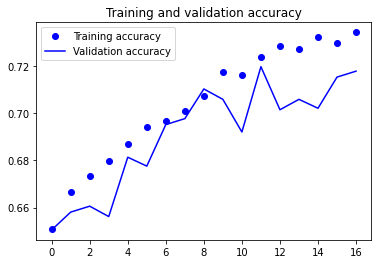

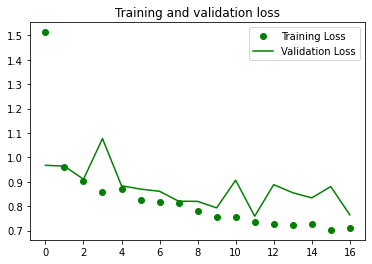

In [26]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']           # 훈련 정확도
val_acc = hist.history['val_accuracy']   # 검증 정확도
loss = hist.history['loss']              # 훈련 손실값
val_loss = hist.history['val_loss']      # 검증 손실값

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### confusion matrix

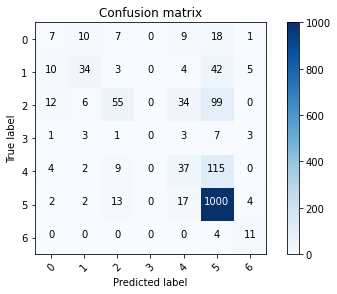

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_val_f)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

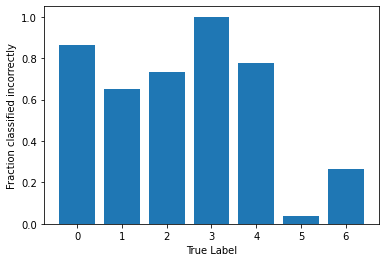

In [28]:
# 예측 부정확도 확인

label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

### Densenet모델

import torch
from torch import optim,nn
from torchvision import models,transforms

torch.manual_seed(10)
torch.cuda.manual_seed(10)

num_classes=7
input_size = 224

model_ft = models.densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, num_classes)

### 테스트 이미지 분류확인
- 분류정확도가 낮은 흑색종(Melanoma)과 분류정확도가 높은 멜라닌세포모반(Melanocytic nevi) 테스트

In [29]:
import numpy as np
from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img, array_to_img

melanoma_img = Image.open('HAM/Melanoma.jpg').resize((100, 75))
nv_img = Image.open('HAM/melanocytic_nevi.jpg').resize((100, 75))

x = image.img_to_array(melanoma_img)
x=np.expand_dims(x, axis=0)
y = image.img_to_array(nv_img)
y=np.expand_dims(y, axis=0)

img1 = np.vstack([x])
img2 = np.vstack([y])

classes1 = model.predict(img1, batch_size=10)
classes2 = model.predict(img2, batch_size=10)

In [30]:
np.set_printoptions(precision=6, suppress=True)
print(classes1[0])       # incorrect

[0. 0. 0. 0. 0. 1. 0.]


In [49]:
print(classes2[0])       # correct

[0. 1. 0. 0. 0. 0. 0.]


### resnet

In [32]:
from tensorflow.keras.applications.resnet50 import ResNet50

# 모델 제작
model_resnet = Sequential()
model_resnet.add(ResNet50(include_top = False, pooling = 'avg')) 
model_resnet.add(Dense(7, activation = 'softmax'))

model_resnet.layers[0].trainable = False
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
_________________________________________________________________


In [33]:
model_resnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
datagen_res = ImageDataGenerator(
    featurewise_center=False,            # input의 평균이 0이 되게함
    featurewise_std_normalization=False, #input을 각 특성의 표준편차로 나눔
    rotation_range=10,                    # 무작위 회전각도
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,                # input을 무작위로 가로로 뒤집음
    vertical_flip=False)                 # input을 무작위로 세로로 뒤집음

datagen_res.fit(x_train_f)

In [35]:
model_resnet.fit(datagen_res.flow(x_train_f, y_train, batch_size=32),
        steps_per_epoch=len(x_train_f) / 32, epochs=20, callbacks=[early_stopping])

Epoch 1/20
199/199 [==============================] - 67s 327ms/step - loss: 1.0637 - accuracy: 0.6748
Epoch 2/20
199/199 [==============================] - 67s 337ms/step - loss: 0.9784 - accuracy: 0.6797
Epoch 3/20
199/199 [==============================] - 67s 337ms/step - loss: 0.9582 - accuracy: 0.6811
Epoch 4/20
199/199 [==============================] - 65s 326ms/step - loss: 0.9365 - accuracy: 0.6830
Epoch 5/20
199/199 [==============================] - 66s 332ms/step - loss: 0.9354 - accuracy: 0.6824
Epoch 6/20
199/199 [==============================] - 65s 325ms/step - loss: 0.9217 - accuracy: 0.6904
Epoch 7/20
199/199 [==============================] - 66s 333ms/step - loss: 0.9195 - accuracy: 0.6864
Epoch 8/20
199/199 [==============================] - 65s 324ms/step - loss: 0.9107 - accuracy: 0.6842
Epoch 9/20
199/199 [==============================] - 69s 346ms/step - loss: 0.9053 - accuracy: 0.6872
Epoch 10/20
199/199 [==============================] - 72s 364ms/step - l

In [36]:
loss, accuracy = model_resnet.evaluate(x_test_f, y_test, verbose=1)

63/63 [==============================] - 21s 327ms/step - loss: 1.0155 - accuracy: 0.6662


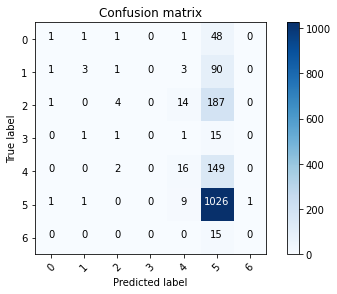

In [37]:
Y_pred_res = model_resnet.predict(x_val_f)
# Convert predictions classes to one hot vectors 
Y_pred_classes_res = np.argmax(Y_pred_res,axis = 1) 
# Convert validation observations to one hot vectors
Y_true_res = np.argmax(y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx_res = confusion_matrix(Y_true_res, Y_pred_classes_res)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_res, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

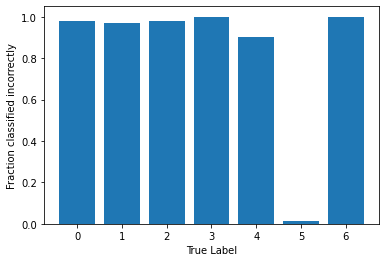

In [38]:
label_frac_error = 1 - np.diag(confusion_mtx_res) / np.sum(confusion_mtx_res, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

### Cross Validation

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 64)       18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 118400)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               15155328  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [40]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1) # 5epoch이상 성능이 좋아지지 않으면 학습멈춤

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('Ham_mnist_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS, BATCH_SIZE):
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [41]:
n_folds=3
epochs=20
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train_f, y_train, test_size=0.2, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
144/144 [==============================] - 58s 402ms/step - loss: 0.7350 - accuracy: 0.7312 - val_loss: 0.7277 - val_accuracy: 0.7275

Epoch 00001: val_loss improved from inf to 0.72769, saving model to Ham_mnist_1.h5
Epoch 2/20
144/144 [==============================] - 59s 411ms/step - loss: 0.6761 - accuracy: 0.7539 - val_loss: 0.7091 - val_accuracy: 0.7412

Epoch 00002: val_loss improved from 0.72769 to 0.70906, saving model to Ham_mnist_1.h5
Epoch 3/20
144/144 [==============================] - 58s 403ms/step - loss: 0.5958 - accuracy: 0.7733 - val_loss: 0.6921 - val_accuracy: 0.7255

Epoch 00003: val_loss improved from 0.70906 to 0.69213, saving model to Ham_mnist_1.h5
Epoch 4/20
144/144 [==============================] - 58s 403ms/step - loss: 0.5359 - accuracy: 0.7997 - val_loss: 0.6850 - val_accuracy: 0.7431

Epoch 00004: val_loss improved from 0.69213 to 0.68504, saving model to Ham_mnist_1.h5
Epoch 5/20
144/144 [==============================]

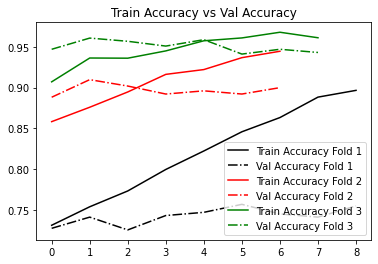

In [42]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

In [43]:
from keras.models import load_model

# checkpoint로 저장된 모델 불러오기
model_kf = load_model('Ham_mnist_1.h5')

In [44]:
model_kf.evaluate(x_test_f, y_test)

63/63 [==============================] - 4s 59ms/step - loss: 1.0349 - accuracy: 0.7475


[1.034930944442749, 0.7474899888038635]

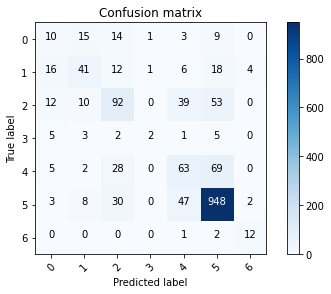

In [45]:
Y_pred = model_kf.predict(x_val_f)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

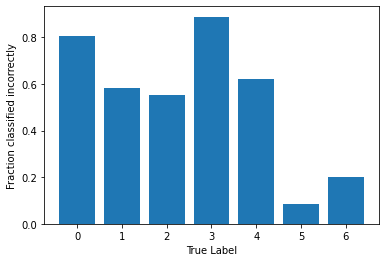

In [46]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [128]:
melanoma_img = Image.open('HAM/Melanoma.jpg').resize((100, 75))
nv_img1 = Image.open('HAM/nv1.jpg').resize((100, 75))
vasc_img1 = Image.open('HAM/vasc1.jpg').resize((100, 75))

x = image.img_to_array(melanoma_img)
x=np.expand_dims(x, axis=0)/255.0
y = image.img_to_array(nv_img1)
y=np.expand_dims(y, axis=0)/255.0
z = image.img_to_array(vasc_img1)
z=np.expand_dims(z, axis=0)/255.0

img3 = np.vstack([x])
img4 = np.vstack([y])
img5 = np.vstack([z])

classes3 = model_kf.predict(img3, batch_size=10)
classes4 = model_kf.predict(img4, batch_size=10)
classes5 = model_kf.predict(img5, batch_size=10)

In [129]:
print(classes3[0])     # incorrect

[0.       0.       0.000018 0.       0.       0.999982 0.      ]


In [130]:
print(classes4[0])     # correct

[0.       0.       0.000002 0.       0.       0.999998 0.      ]


In [131]:
print(classes5[0])     # incorrect

[0.000041 0.843846 0.005225 0.001264 0.000054 0.148912 0.000658]


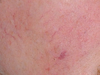

In [132]:
vasc_img1

# 결론

### 모델
- train, validation 데이터로 CNN모델을 K-fold validation을 통해 학습
- 0.95정도의 정확도를 가진 모델을 얻었지만 test데이터로 확인한 결과 0.75정도의 정확도밖에 가지지 못한 모델임을 확인(과적합 가능성)
- label이 imbalanced한 점이 하나의 이유일 것 같음

#### Imbalanced한 이미지 처리가능한 방법
- 다운샘플링 대신 치핑(원본이미지를 작은타일로 분할)
- 거의 동일한 클래스 병합
- 특정 클래스 리샘플링(소수 클래스 오버샘플링) : 오버샘플링 클래스의 과적합 초래하는 단점 존재
- 손실함수 조정(focal loss)(파이썬에 binary, sparse존재)

### 활용방안
- 초기 피부질환 감별 및 예후 예측 가능
- 의료뿐 아니라 코스메틱(뷰티) 분야에도 적용 가능

### 아쉬운점
- 본래 AI Hub 개방데이터인 피부질환진단 의료 이미지(피부질환, 종양등 32종류의 피부질환 및 정상피부 데이터,약 10만건)를 사용하려 했으나 심사기간 및 승인이 필요하여 사용하지 못한점
- 위에서 언급한 것처럼 불균형한 이미지데이터를 처리해보지 못한점
- 전이학습 적용하지 못한점
- 따로 서비스화하지 못한점

In [152]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [150]:
# requirements.txt (option)
import session_info

session_info.show()